# 量子位相推定

量子アルゴリズムの回路を構築するときは、個々の量子ゲートだけでなく、より高いレベルの操作を考えると役立ちます。 `pytket` では、基礎となる回路の複雑さを抽象化するボックス構造を使用して回路を構築できます。  
このノートブックは、さまざまなボックス タイプを紹介するユーザー マニュアルの [boxes section](https://tket.quantinuum.com/user-manual/manual_circuit.html#boxes) を補完することを目的としています。

`pytket`のボックスをデモンストレーションするために、量子位相推定アルゴリズム (QPE) を考えます。  
これは、Shor のアルゴリズムや量子化学へのフォールトトレラントなアプローチを含むいくつかの量子アルゴリズムにおける重要なサブルーチンです。

## 位相推定の概要

量子位相推定アルゴリズムを使用すると、ユニタリ演算子 $U$ の固有値を希望の精度で推定できます。

$U$ の固有値は単位円上にあり、次の固有値方程式が得られます。

$$
\begin{equation}
U |\psi \rangle = e^{2 \pi i \theta} |\psi\rangle\,, \quad 0 \leq \theta \leq 1
\end{equation}
$$

ここで $|\psi \rangle$ は演算子 $U$ の固有状態です。  
位相推定では、$\theta$ を近似することで固有値 $e^{2 \pi i \theta}$ を推定します。


量子位相推定の回路自体は、ボックスとして実現できるいくつかのサブルーチンで構成されています。

![](fig/phase_est.png "量子位相推定回路")

QPE は通常 3 つの段階に分かれています

1. まず、1 つのレジスタに初期状態を準備します。  
並行して、いくつかの補助 (測定) 量子ビットにアダマール ゲートを使用して均一な重ね合わせ状態を準備します。補助量子ビットの数によって、位相 $\theta$ をどの程度正確に推定できるかが決まります。

2. 次に、制御$U$ ゲートを連続して適用します。これには、上記の固有値方程式に従って補助量子ビットに位相を「キックバック」する効果があります。

3. 最後に、逆量子フーリエ変換 (QFT) を適用します。これは本質的に破壊的干渉の役割を果たし、「望ましくない状態」による振幅を抑制し、できれば単一の結果 (または少数の結果) を高い確率で測定できるようにします。


最初の点に関しては微妙な点があります。使用される初期状態は $U$ の正確な固有状態にすることができますが、$U$ の固有値が事前にわかっていない場合、これを準備するのは難しい場合があります。あるいは、位相推定が $U$ の固有空間に投影されるため、固有状態の線形結合である初期状態を使用することもできます。

また、$U$ を量子回路で実装できると仮定します。  
化学アプリケーションでは、$U$ は $U=e^{-iHt}$ の形式にすることができます。  
ここで、$H$ は対象となるシステムのハミルトニアンです。  
教科書的なアルゴリズムでは、適用する制御ユニタリーの数は、測定量子ビットの数に応じて指数関数的に増加します。  
これにより、より大きな量子回路を犠牲にして、より高い精度が可能になります。

## 量子フーリエ変換（Quantum Fourier Transform、QFT）

QPE アルゴリズムの他の部分を検討する前に、量子フーリエ変換 (QFT) サブルーチンに焦点を当てましょう。

数学的には、QFT は次の作用のことです。

$$
\begin{equation}
QFT : |j\rangle\ \longmapsto \frac{1}{\sqrt{N}} \sum_{k=0}^{N - 1} e^{2 \pi ijk/N}|k\rangle, \quad N= 2^n
\end{equation}
$$

これは、入力が量子状態 $|j\rangle$ であることを除けば、本質的には離散フーリエ変換です。

$n$個のアダマール ゲート、$\lfloor{\frac{n}{2}}\rfloor$個のスワップ ゲート、および $\frac{n(n-1)}{2}$個の制御ユニタリ回転ゲート $\text{CU1}$ を使用して、$n$ 量子ビット QFT の回路を構築できます。

$$
 \begin{equation}
U1(\phi) =
 \begin{pmatrix}
 1 & 0 \\
 0 & e^{i \pi \phi}
 \end{pmatrix}\, , \quad
 CU1(\phi) =
 \begin{pmatrix}
 1 & 0 & 0 & 0 \\
 0 & 1 & 0 & 0 \\
 0 & 0 & 1 & 0 \\
 0 & 0 & 0 & e^{i \pi \phi}
 \end{pmatrix}
 \end{equation}
$$

3 量子ビットの量子フーリエ変換の回路は次のとおりです。

![](fig/qft.png "QFT 回路")

手動でゲート操作を追加することで、`pytket`でこの回路を構築できます。

3 量子ビットの QFT を構築しましょう

In [1]:
from pytket.circuit import Circuit
from pytket.circuit.display import render_circuit_jupyter

In [2]:
qft3_circ = Circuit(3)
qft3_circ.H(0)
qft3_circ.CU1(0.5, 1, 0)
qft3_circ.CU1(0.25, 2, 0)
qft3_circ.H(1)
qft3_circ.CU1(0.5, 2, 1)
qft3_circ.H(2)
qft3_circ.SWAP(0, 2)
render_circuit_jupyter(qft3_circ)

次のように量子ビットを反復処理することで、量子フーリエ変換を $n$ 量子ビットに一般化できます。

In [3]:
def build_qft_circuit(n_qubits: int) -> Circuit:
    circ = Circuit(n_qubits, name="QFT")
    for i in range(n_qubits):
        circ.H(i)
        for j in range(i + 1, n_qubits):
            circ.CU1(1 / 2 ** (j - i), j, i)
    for k in range(0, n_qubits // 2):
        circ.SWAP(k, n_qubits - k - 1)
    return circ

In [4]:
qft4_circ: Circuit = build_qft_circuit(4)
render_circuit_jupyter(qft4_circ)

一般化された回路ができたので、それを`CircBox`にラップし、サブルーチンとして別の回路に追加できます。

In [5]:
from pytket.circuit import CircBox

In [6]:
qft4_box: CircBox = CircBox(qft4_circ)
qft_circ = Circuit(4).add_gate(qft4_box, [0, 1, 2, 3])
render_circuit_jupyter(qft_circ)

`CircBox`が基礎となる回路から`QFT`という名前を継承していることに注目してください。

Recall that in our phase estimation algorithm we need to use the inverse QFT.

$$
\begin{equation}
\text{QFT}^† : \frac{1}{\sqrt{N}} \sum_{k=0}^{N - 1} e^{2 \pi ijk/N}|k\rangle \longmapsto |j\rangle\,, \quad N= 2^n
\end{equation}
$$


Now that we have the QFT circuit we can obtain the inverse by using `CircBox.dagger`. We can also verify that this is correct by inspecting the circuit inside with `CircBox.get_circuit()`.

位相推定アルゴリズムでは逆 QFT を使用する必要があることを思い出してください。

$$
\begin{equation}
\text{QFT}^† : \frac{1}{\sqrt{N}} \sum_{k=0}^{N - 1} e^{2 \pi ijk/N}|k\rangle \longmapsto |j\rangle\,, \quad N= 2^n
\end{equation}
$$

QFT 回路ができたので、`CircBox.dagger` を使用して逆関数を取得できます。  
`CircBox.get_circuit()` で内部の回路を可視化することで、これが正しいことを確認することもできます。

In [8]:
inv_qft4_box = qft4_box.dagger
render_circuit_jupyter(inv_qft4_box.get_circuit())

## 位相推定回路の構築

これで、QPE 回路全体を構築する関数を定義できるようになりました。この関数に状態準備回路とユニタリ回路を入力として受け取るようにすることもできます。この関数には、位相推定の精度を決定する入力として測定量子ビットの数も含まれます。

In [9]:
from pytket.circuit import QControlBox

In [10]:
def build_phase_estimation_circuit(
    n_measurement_qubits: int, state_prep_circuit: Circuit, unitary_circuit: Circuit
) -> Circuit:
    # Define a Circuit with a measurement and prep register
    qpe_circ: Circuit = Circuit()
    n_state_prep_qubits = state_prep_circuit.n_qubits
    measurement_register = qpe_circ.add_q_register("m", n_measurement_qubits)
    state_prep_register = qpe_circ.add_q_register("p", n_state_prep_qubits)
    qpe_circ.add_circuit(state_prep_circuit, list(state_prep_register))

    # Create a controlled unitary with a single control qubit
    unitary_circuit.name = "U"
    controlled_u_gate = QControlBox(CircBox(unitary_circuit), 1)

    # Add Hadamard gates to every qubit in the measurement register
    for m_qubit in measurement_register:
        qpe_circ.H(m_qubit)

    # Add all (2**n_measurement_qubits - 1) of the controlled unitaries sequentially
    for m_qubit in range(n_measurement_qubits):
        control_index = n_measurement_qubits - m_qubit - 1
        control_qubit = [measurement_register[control_index]]
        for _ in range(2**m_qubit):
            qpe_circ.add_qcontrolbox(
                controlled_u_gate, control_qubit + list(state_prep_register)
            )

    # Finally, append the inverse qft and measure the qubits
    qft_box = CircBox(build_qft_circuit(n_measurement_qubits))
    inverse_qft_box = qft_box.dagger
    qpe_circ.add_circbox(inverse_qft_box, list(measurement_register))
    qpe_circ.measure_register(measurement_register, "c")
    return qpe_circ

## 自明な固有状態による位相推定

$\text{U1}$ ゲートの自明な $|1\rangle$ 固有状態を準備して、回路の構築をテストしてみましょう。次に、位相推定回路が期待される固有値を返すかどうかを確認できます。

$$
\begin{equation}
U1(\phi)|1\rangle = e^{i \pi \phi}|1\rangle = e^{2 \pi i \theta} |1\rangle \implies \theta = \frac{\phi}{2}
\end{equation}
$$

したがって、理想的な位相 $\theta$ は $U1$ ゲートへの入力角度 $\phi$ の半分になると予想されます。

In [11]:
prep_circuit = Circuit(1).X(0)  # prepare the |1> eigenstate of U1

In [12]:
input_angle = 0.73  # angle as number of half turns

In [13]:
unitary_circuit = Circuit(1).U1(input_angle, 0)  # Base unitary for controlled U ops

In [14]:
qpe_circ_trivial = build_phase_estimation_circuit(
    4, state_prep_circuit=prep_circuit, unitary_circuit=unitary_circuit
)

In [15]:
render_circuit_jupyter(qpe_circ_trivial)

ノイズのない`AerBackend`シミュレーターを使用して、位相推定回路を実行してみましょう。

In [16]:
from pytket.extensions.qiskit import AerBackend

In [17]:
backend = AerBackend()

In [18]:
compiled_circ = backend.get_compiled_circuit(qpe_circ_trivial)

In [19]:
n_shots = 1000
result = backend.run_circuit(compiled_circ, n_shots)

In [20]:
print(result.get_counts())

Counter({(0, 1, 1, 0): 916, (0, 1, 0, 1): 32, (0, 1, 1, 1): 22, (0, 1, 0, 0): 14, (1, 0, 0, 0): 7, (1, 0, 0, 1): 2, (1, 0, 1, 1): 2, (1, 1, 1, 1): 2, (0, 0, 0, 0): 1, (0, 0, 0, 1): 1, (1, 1, 1, 0): 1})


In [21]:
from pytket.backends.backendresult import BackendResult
import matplotlib.pyplot as plt

QPE Notebookのプロット機能

In [22]:
def plot_qpe_results(
    sim_result: BackendResult,
    n_strings: int = 4,
    dark_mode: bool = False,
    y_limit: int = 1000,
) -> None:
    """
    Plots results in a barchart given a BackendResult. the number of stings displayed
    can be specified with the n_strings argument.
    """
    counts_dict = sim_result.get_counts()
    sorted_shots = counts_dict.most_common()
    n_most_common_strings = sorted_shots[:n_strings]
    x_axis_values = [str(entry[0]) for entry in n_most_common_strings]  # basis states
    y_axis_values = [entry[1] for entry in n_most_common_strings]  # counts
    if dark_mode:
        plt.style.use("dark_background")
    fig = plt.figure()
    ax = fig.add_axes((0, 0, 0.75, 0.5))
    color_list = ["orange"] * (len(x_axis_values))
    ax.bar(
        x=x_axis_values,
        height=y_axis_values,
        color=color_list,
    )
    ax.set_title(label="Results")
    plt.ylim([0, y_limit])
    plt.xlabel("Basis State")
    plt.ylabel("Number of Shots")
    plt.show()

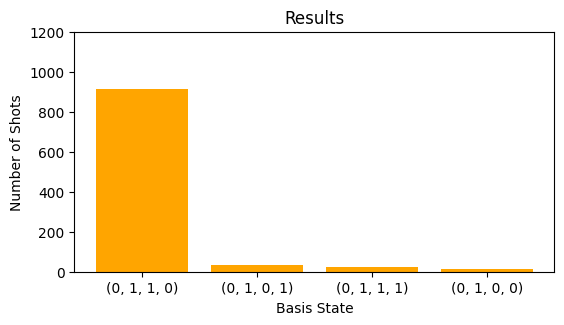

In [23]:
plot_qpe_results(result, y_limit=int(1.2 * n_shots))

予想どおり、高い確率で 1 つの結果が表示されます。次に、出力ビット文字列から $\theta$ の近似値を抽出しましょう。

$j$ が最も一般的に測定されるビット文字列の整数表現であるとします。

$$
\begin{equation}
\theta_{estimate} = \frac{j}{N}
\end{equation}
$$

ここで $N = 2 ^m$ であり、 $m$ は測定量子ビットの数です。

In [24]:
from pytket.backends.backendresult import BackendResult

In [25]:
def single_phase_from_backendresult(result: BackendResult) -> float:
    # Extract most common measurement outcome
    basis_state = result.get_counts().most_common()[0][0]
    bitstring = "".join([str(bit) for bit in basis_state])
    integer_j = int(bitstring, 2)

    # Calculate theta estimate
    return integer_j / (2 ** len(bitstring))

In [26]:
theta = single_phase_from_backendresult(result)

In [27]:
print(theta)

0.375


In [28]:
print(input_angle / 2)

0.365


出力は予想通り、入力角度 $\phi$ の半分に近くなります。誤差 $E$ を小数点以下 3 桁まで計算してみましょう。

$$
\begin{equation}
E = |\phi - 2 \, \theta_{estimate}|
\end{equation}
$$

In [29]:
error = round(abs(input_angle - (2 * theta)), 3)
print(error)

0.02


## 時間発展による位相推定

位相推定アルゴリズムでは、制御されたユニタリ演算を繰り返し実行します。ここで紹介する 標準的なQPEでは、制御ユニタリの数は $2^m - 1$ になります。ここで、$m$ は測定量子ビットの数です。

上の例では、正確なフェーズが事前にわかっている QPE の簡単なインスタンスを示しました。   
QPE をより現実的に適用するには、いくつかの重要な状態の準備が必要になります。

化学または物性物理学の場合、 $U$ は通常、時間発展演算子 $U(t) = e^{- i H t}$ になります。  
ここで、 $H$ は問題のハミルトニアンです。  
  

パウリ文字列 $P_j$ と複素係数 $\alpha_j$ に関して $H$ に対して次の分解があったとします。

$$
\begin{equation}
H = \sum_j \alpha_j P_j\,, \quad \, P_j \in \{I, \,X, \,Y, \,Z\}^{\otimes n}
\end{equation}
$$

ここで、パウリ文字列という用語は、パウリ演算子のテンソル積を指します。これらの文字列は、$2^n \times 2^n$ 行列の正規直交基底を形成します。

上記の形式のハミルトニアンがある場合、$U(t)$ をパウリ ガジェット回路のシーケンスとして実装できます。これは、pytket の [PauliExpBox](https://tket.quantinuum.com/api-docs/circuit.html#pytket.circuit.PauliExpBox) コンストラクトを使用して行うことができます。 `PauliExpBox` の詳細については、[user manual](https://tket.quantinuum.com/user-manual/manual_circuit.html#pauli-exponential-boxes) を参照してください。

時間発展演算子 $U(t)$ を実装する回路を作成したら、[QControlBox](https://tket.quantinuum.com/api-docs/circuit.html#pytket.circuit.QControlBox) を使用して制御された $U(t)$ 演算を構築できます。  
基本ユニタリーが `PauliExpBox` のシーケンスである場合、回路を単純化するために利用できる構造がいくつかあります。  
[blog post](https://tket.quantinuum.com/blog/posts/controlled_gates/) を参照してください。 より詳しくは[ConjugationBox](https://tket.quantinuum.com/api-docs/circuit.html#pytket.circuit.ConjugationBox) を参照してください。

演習として、位相推定を使用して二原子水素 $H_2$ の基底状態を計算しみましょう。

## さらに学ぶための提案

* ベイズ位相推定に関する量子論文 -> https://arxiv.org/pdf/2306.16608.pdf
* `ConjugationBox` (制御ゲートの効率的な回路) に関するブログ投稿 -> https://tket.quantinuum.com/blog/posts/controlled_gates/